In [1]:
import xgboost
import numpy as np
import pandas as pd
import csv
import math
import random
import pickle
import matplotlib.pyplot as plt
import sklearn
from typing import Tuple
from datetime import datetime

In [2]:
training_df = pd.read_csv('train-data-10-year.csv')
y_train = training_df['price']
X_train = training_df.drop('price', axis=1)

In [3]:
training_df = pd.read_csv('test-data-10-year.csv')
y_test = training_df['price']
X_test = training_df.drop('price', axis=1)

In [4]:
def train_val_split(X, y, val_size, random_state):
    # TODO: implement your own train_val_split
    
    
    X_train = X.sample(frac = 0.9,random_state = random_state)
    X_temp = X.drop(X_train.index)
    y_train = y.sample(frac = 0.9,random_state = random_state)
    y_temp = y.drop(y_train.index)
    
    X_val = X_temp.sample(frac = 0.5,random_state = random_state)
    X_test = X_temp.drop(X_val.index)
    y_val = y_temp.sample(frac = 0.5,random_state = random_state)
    y_test = y_temp.drop(y_val.index) 
    return X_train, X_val, X_test, y_train, y_val, y_test

In [79]:
# random_state = random.getstate()[1][0]

# X_train, X_val, X_test, y_train, y_val, y_test = train_val_split(X, y, X.size, random_state)

# print(X_train)
#print(y_train)

In [41]:
#n_estimators
#minchildweight[i for i in range(10)]以及max_depth[i for i in range(10)]
#gamma[0,inf]
#subsample(0.5,1]以及colsample_bytree(0,1]
#regalpha[0,inf]以及reglambda[0,inf]
#learning_rate(0,inf]
#initparams = {'learning_rate': 0.1,  'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
#                    'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
params = {'learning_rate': 0.1,  'max_depth': 8, 'min_child_weight': 1, 'seed': 0,
                    'subsample': 0.6, 'colsample_bytree': 0.9, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 16}

In [51]:
XGB_train = xgboost.DMatrix(X_train, label=y_train)
XGB_test = xgboost.DMatrix(X_test, label=y_test)

def r2(predt: np.ndarray, dtrain: xgboost.DMatrix) -> Tuple[str, float]:
    y = dtrain.get_label()
    score = 1 - sum((y - predt)**2)/sum((y - np.mean(np.array(y)))**2)
    return 'R2', float(score)

gridsearch_params = [
    (i, j)
    for i in [0]
    for j in [16]
]
gridsearch1 = 'reg_alpha'
gridsearch2 = 'reg_lambda'


plot_dict = {}
from sklearn.metrics import r2_score

for i,j in gridsearch_params:
    currentDateAndTime = datetime.now()
    print("now:",i,j)
    params[gridsearch1] = i
    params[gridsearch2] = j
    #early_stop = xgboost.callback.EarlyStopping(rounds=20,metric_name='rmse')
    xgbcv = xgboost.cv(
        params,
        XGB_train,
        nfold=5,
        custom_metric=r2,
        num_boost_round = 2000#,
        #callbacks = [early_stop]
    )
    print(xgbcv)
    plot_dict[(i,j)] = (xgbcv['test-R2-mean'],xgbcv['train-R2-mean'])
    print(xgbcv['test-R2-mean'].max())
    print("time:",datetime.now()-currentDateAndTime)

now: 0 16
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std  \
0        9.992286e+06    10691.104409    9.992960e+06   41363.894387   
1        9.089740e+06    15798.699496    9.091540e+06   40781.577026   
2        8.274513e+06    12948.046453    8.277775e+06   40604.431092   
3        7.540112e+06    11066.279287    7.545561e+06   40155.259484   
4        6.889092e+06    11914.685732    6.897073e+06   36188.381227   
...               ...             ...             ...            ...   
1995     4.677382e+05     4321.261982    1.513355e+06   31693.882830   
1996     4.676403e+05     4337.649314    1.513375e+06   31699.772255   
1997     4.675216e+05     4357.768948    1.513404e+06   31690.361801   
1998     4.673993e+05     4346.394044    1.513375e+06   31677.063687   
1999     4.672867e+05     4347.744029    1.513349e+06   31678.743952   

      train-R2-mean  train-R2-std  test-R2-mean  test-R2-std  
0         -2.443396      0.006104     -2.444215     0.022315  

0 16


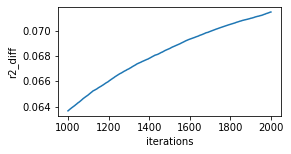

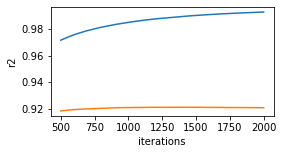

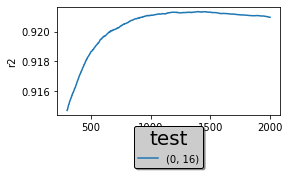

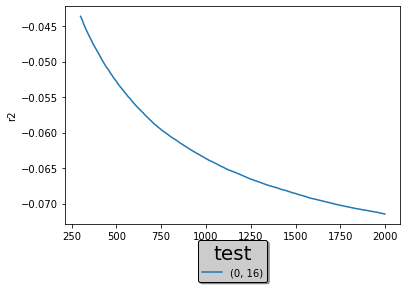

In [52]:
#print(plot_dict)
for i,j in plot_dict:
    print(i,j)
    plt.figure(figsize=(4, 2))
    plt.plot(np.squeeze(plot_dict[(i,j)][1][-1000:]-plot_dict[(i,j)][0][-1000:]))
    plt.ylabel('r2_diff')
    plt.xlabel('iterations')
    plt.show()
    plt.figure(figsize=(4, 2))
    plt.plot(np.squeeze(plot_dict[(i,j)][1][500:]))
    plt.plot(np.squeeze(plot_dict[(i,j)][0][500:]))
    plt.ylabel('r2')
    plt.xlabel('iterations')
    plt.show()

plt.figure(figsize=(4, 2))
for i,j in plot_dict:
    if(plot_dict[(i,j)][0].max()<0.915):
        continue
    plt.plot(np.squeeze(plot_dict[(i,j)][0][300:]),label = (i,j))
    plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
plt.ylabel('r2')
plt.xlabel('iterations')
plt.show()

for i,j in plot_dict:
    if(plot_dict[(i,j)][0].max()<0.915):
        continue
    plt.plot(np.squeeze(plot_dict[(i,j)][0][300:] - np.squeeze(plot_dict[(i,j)][1][300:])),label = (i,j))
    plt.legend(
    loc='upper center', bbox_to_anchor=(0.5, -0.05),
    fontsize=10,
    shadow=True,
    facecolor='#ccc',
    edgecolor='#000',
    title='test',
    title_fontsize=20)
plt.ylabel('r2')
plt.xlabel('iterations')
plt.show()

In [42]:
xgbrt = xgboost.train(params,
        dtrain = XGB_train,
        #5000,
        evals = [(XGB_test,'eval'), (XGB_train,'train')],
        num_boost_round = 5000,
        custom_metric=r2
        #feval = r2
        )

[0]	eval-rmse:10061392.72552	eval-R2:-2.53701	train-rmse:9988736.40656	train-R2:-2.44093
[1]	eval-rmse:9144829.44616	eval-R2:-1.92194	train-rmse:9080061.94412	train-R2:-1.84336
[2]	eval-rmse:8318607.24156	eval-R2:-1.41780	train-rmse:8260375.94096	train-R2:-1.35317
[3]	eval-rmse:7578733.07200	eval-R2:-1.00684	train-rmse:7526325.42560	train-R2:-0.95353
[4]	eval-rmse:6920688.86405	eval-R2:-0.67347	train-rmse:6871161.07799	train-R2:-0.62823
[5]	eval-rmse:6331831.78602	eval-R2:-0.40081	train-rmse:6281192.24737	train-R2:-0.36062
[6]	eval-rmse:5805787.72796	eval-R2:-0.17772	train-rmse:5756154.02614	train-R2:-0.14266
[7]	eval-rmse:5348135.31228	eval-R2:0.00063	train-rmse:5301154.80792	train-R2:0.03084
[8]	eval-rmse:4940663.00624	eval-R2:0.14711	train-rmse:4893709.26985	train-R2:0.17409
[9]	eval-rmse:4568342.32606	eval-R2:0.27082	train-rmse:4518876.33396	train-R2:0.29577
[10]	eval-rmse:4246008.92871	eval-R2:0.37008	train-rmse:4193041.59673	train-R2:0.39366
[11]	eval-rmse:3964410.79100	eval-R2:0

[95]	eval-rmse:1739245.73837	eval-R2:0.89431	train-rmse:1455225.72281	train-R2:0.92697
[96]	eval-rmse:1735483.56244	eval-R2:0.89477	train-rmse:1450416.74939	train-R2:0.92745
[97]	eval-rmse:1733630.47791	eval-R2:0.89499	train-rmse:1447484.85488	train-R2:0.92774
[98]	eval-rmse:1732890.78752	eval-R2:0.89508	train-rmse:1445901.59871	train-R2:0.92790
[99]	eval-rmse:1732055.98231	eval-R2:0.89518	train-rmse:1443780.20298	train-R2:0.92811
[100]	eval-rmse:1731533.72337	eval-R2:0.89524	train-rmse:1442381.39971	train-R2:0.92825
[101]	eval-rmse:1731789.63775	eval-R2:0.89521	train-rmse:1441397.16171	train-R2:0.92835
[102]	eval-rmse:1728119.59318	eval-R2:0.89566	train-rmse:1437219.38761	train-R2:0.92876
[103]	eval-rmse:1726543.95766	eval-R2:0.89585	train-rmse:1434632.35098	train-R2:0.92902
[104]	eval-rmse:1725241.98477	eval-R2:0.89600	train-rmse:1431195.21452	train-R2:0.92936
[105]	eval-rmse:1724607.16900	eval-R2:0.89608	train-rmse:1429122.55542	train-R2:0.92956
[106]	eval-rmse:1724226.33200	eval-R2

[189]	eval-rmse:1649080.74261	eval-R2:0.90498	train-rmse:1280617.35262	train-R2:0.94344
[190]	eval-rmse:1647569.98207	eval-R2:0.90516	train-rmse:1277424.78068	train-R2:0.94372
[191]	eval-rmse:1647063.28445	eval-R2:0.90521	train-rmse:1276547.68338	train-R2:0.94380
[192]	eval-rmse:1645972.51126	eval-R2:0.90534	train-rmse:1275145.40686	train-R2:0.94392
[193]	eval-rmse:1645282.78976	eval-R2:0.90542	train-rmse:1273931.49252	train-R2:0.94403
[194]	eval-rmse:1644968.71255	eval-R2:0.90546	train-rmse:1273046.24321	train-R2:0.94411
[195]	eval-rmse:1643494.27597	eval-R2:0.90563	train-rmse:1271063.20719	train-R2:0.94428
[196]	eval-rmse:1642687.24323	eval-R2:0.90572	train-rmse:1269734.12777	train-R2:0.94440
[197]	eval-rmse:1641587.27743	eval-R2:0.90584	train-rmse:1268242.50306	train-R2:0.94453
[198]	eval-rmse:1640395.19575	eval-R2:0.90598	train-rmse:1266845.01398	train-R2:0.94465
[199]	eval-rmse:1640282.79048	eval-R2:0.90599	train-rmse:1266105.13240	train-R2:0.94472
[200]	eval-rmse:1639738.05267	ev

[283]	eval-rmse:1597744.76761	eval-R2:0.91081	train-rmse:1155206.90227	train-R2:0.95398
[284]	eval-rmse:1597221.04818	eval-R2:0.91087	train-rmse:1154336.38110	train-R2:0.95405
[285]	eval-rmse:1596852.02420	eval-R2:0.91091	train-rmse:1153302.25900	train-R2:0.95413
[286]	eval-rmse:1596928.93911	eval-R2:0.91090	train-rmse:1152219.48505	train-R2:0.95422
[287]	eval-rmse:1596557.06695	eval-R2:0.91094	train-rmse:1151660.48087	train-R2:0.95426
[288]	eval-rmse:1596213.81604	eval-R2:0.91098	train-rmse:1150635.22437	train-R2:0.95434
[289]	eval-rmse:1595961.55036	eval-R2:0.91100	train-rmse:1150438.05568	train-R2:0.95436
[290]	eval-rmse:1595310.59820	eval-R2:0.91108	train-rmse:1149346.57122	train-R2:0.95444
[291]	eval-rmse:1595085.58904	eval-R2:0.91110	train-rmse:1148455.52352	train-R2:0.95451
[292]	eval-rmse:1594935.69781	eval-R2:0.91112	train-rmse:1147407.29117	train-R2:0.95460
[293]	eval-rmse:1595201.73252	eval-R2:0.91109	train-rmse:1146101.84364	train-R2:0.95470
[294]	eval-rmse:1594953.14494	ev

[377]	eval-rmse:1572326.62532	eval-R2:0.91362	train-rmse:1058144.09585	train-R2:0.96139
[378]	eval-rmse:1572111.40032	eval-R2:0.91365	train-rmse:1057480.42178	train-R2:0.96144
[379]	eval-rmse:1572198.68660	eval-R2:0.91364	train-rmse:1056576.20027	train-R2:0.96150
[380]	eval-rmse:1572337.62028	eval-R2:0.91362	train-rmse:1055871.51194	train-R2:0.96155
[381]	eval-rmse:1571923.99162	eval-R2:0.91367	train-rmse:1054106.44946	train-R2:0.96168
[382]	eval-rmse:1570935.25645	eval-R2:0.91377	train-rmse:1052697.11531	train-R2:0.96178
[383]	eval-rmse:1571010.47238	eval-R2:0.91377	train-rmse:1051821.78786	train-R2:0.96185
[384]	eval-rmse:1570866.80768	eval-R2:0.91378	train-rmse:1051673.45638	train-R2:0.96186
[385]	eval-rmse:1570509.97476	eval-R2:0.91382	train-rmse:1050310.05598	train-R2:0.96196
[386]	eval-rmse:1570404.51381	eval-R2:0.91383	train-rmse:1049269.53309	train-R2:0.96203
[387]	eval-rmse:1570332.46725	eval-R2:0.91384	train-rmse:1048927.65710	train-R2:0.96206
[388]	eval-rmse:1569440.09168	ev

[471]	eval-rmse:1550031.27150	eval-R2:0.91605	train-rmse:978897.10568	train-R2:0.96695
[472]	eval-rmse:1549628.92114	eval-R2:0.91610	train-rmse:978034.88011	train-R2:0.96701
[473]	eval-rmse:1549688.02090	eval-R2:0.91609	train-rmse:977187.36688	train-R2:0.96707
[474]	eval-rmse:1549607.31460	eval-R2:0.91610	train-rmse:976699.55463	train-R2:0.96710
[475]	eval-rmse:1549740.79458	eval-R2:0.91609	train-rmse:975627.03227	train-R2:0.96717
[476]	eval-rmse:1549924.30597	eval-R2:0.91607	train-rmse:975194.86018	train-R2:0.96720
[477]	eval-rmse:1549922.63619	eval-R2:0.91607	train-rmse:974647.96214	train-R2:0.96724
[478]	eval-rmse:1549883.72478	eval-R2:0.91607	train-rmse:974113.20831	train-R2:0.96727
[479]	eval-rmse:1549284.59845	eval-R2:0.91614	train-rmse:972840.67060	train-R2:0.96736
[480]	eval-rmse:1549115.87669	eval-R2:0.91615	train-rmse:971968.34483	train-R2:0.96742
[481]	eval-rmse:1548918.65825	eval-R2:0.91617	train-rmse:971637.29384	train-R2:0.96744
[482]	eval-rmse:1548811.09815	eval-R2:0.916

[566]	eval-rmse:1535565.98756	eval-R2:0.91761	train-rmse:912434.30931	train-R2:0.97129
[567]	eval-rmse:1535375.29791	eval-R2:0.91763	train-rmse:911875.10066	train-R2:0.97132
[568]	eval-rmse:1535237.22003	eval-R2:0.91765	train-rmse:911143.32891	train-R2:0.97137
[569]	eval-rmse:1534926.06417	eval-R2:0.91768	train-rmse:910888.77001	train-R2:0.97139
[570]	eval-rmse:1534905.38851	eval-R2:0.91768	train-rmse:910609.79614	train-R2:0.97140
[571]	eval-rmse:1534806.78593	eval-R2:0.91770	train-rmse:910236.06919	train-R2:0.97143
[572]	eval-rmse:1534788.72406	eval-R2:0.91770	train-rmse:909687.99108	train-R2:0.97146
[573]	eval-rmse:1534803.49052	eval-R2:0.91770	train-rmse:909310.95658	train-R2:0.97149
[574]	eval-rmse:1534564.29806	eval-R2:0.91772	train-rmse:908725.24231	train-R2:0.97152
[575]	eval-rmse:1534598.89793	eval-R2:0.91772	train-rmse:908235.18085	train-R2:0.97155
[576]	eval-rmse:1534745.43654	eval-R2:0.91770	train-rmse:907454.27733	train-R2:0.97160
[577]	eval-rmse:1534676.31539	eval-R2:0.917

[661]	eval-rmse:1526183.73725	eval-R2:0.91862	train-rmse:857706.90313	train-R2:0.97463
[662]	eval-rmse:1526557.35595	eval-R2:0.91858	train-rmse:856841.79912	train-R2:0.97468
[663]	eval-rmse:1526489.76763	eval-R2:0.91858	train-rmse:856110.66660	train-R2:0.97472
[664]	eval-rmse:1526725.05286	eval-R2:0.91856	train-rmse:855614.19062	train-R2:0.97475
[665]	eval-rmse:1526851.00631	eval-R2:0.91855	train-rmse:854826.14811	train-R2:0.97480
[666]	eval-rmse:1526878.17380	eval-R2:0.91854	train-rmse:854659.74836	train-R2:0.97481
[667]	eval-rmse:1527053.59593	eval-R2:0.91852	train-rmse:854295.49126	train-R2:0.97483
[668]	eval-rmse:1527104.28719	eval-R2:0.91852	train-rmse:853651.61232	train-R2:0.97487
[669]	eval-rmse:1527203.69619	eval-R2:0.91851	train-rmse:853062.33985	train-R2:0.97490
[670]	eval-rmse:1527143.44371	eval-R2:0.91851	train-rmse:852767.46786	train-R2:0.97492
[671]	eval-rmse:1526977.33779	eval-R2:0.91853	train-rmse:852316.05759	train-R2:0.97495
[672]	eval-rmse:1527087.50332	eval-R2:0.918

[756]	eval-rmse:1521539.93212	eval-R2:0.91911	train-rmse:811593.51073	train-R2:0.97728
[757]	eval-rmse:1521609.93846	eval-R2:0.91910	train-rmse:811070.42204	train-R2:0.97731
[758]	eval-rmse:1521370.17162	eval-R2:0.91913	train-rmse:810591.81885	train-R2:0.97734
[759]	eval-rmse:1521126.05008	eval-R2:0.91916	train-rmse:810253.23385	train-R2:0.97736
[760]	eval-rmse:1520938.73202	eval-R2:0.91917	train-rmse:810094.58061	train-R2:0.97737
[761]	eval-rmse:1520719.84307	eval-R2:0.91920	train-rmse:809686.02102	train-R2:0.97739
[762]	eval-rmse:1520777.06159	eval-R2:0.91919	train-rmse:809123.20516	train-R2:0.97742
[763]	eval-rmse:1520585.76054	eval-R2:0.91921	train-rmse:808632.37692	train-R2:0.97745
[764]	eval-rmse:1520447.67859	eval-R2:0.91923	train-rmse:807987.38413	train-R2:0.97749
[765]	eval-rmse:1520424.82422	eval-R2:0.91923	train-rmse:807799.82774	train-R2:0.97750
[766]	eval-rmse:1520242.84146	eval-R2:0.91925	train-rmse:807406.82672	train-R2:0.97752
[767]	eval-rmse:1520043.16781	eval-R2:0.919

[851]	eval-rmse:1515494.76875	eval-R2:0.91975	train-rmse:771406.85838	train-R2:0.97948
[852]	eval-rmse:1515548.13252	eval-R2:0.91975	train-rmse:770987.30925	train-R2:0.97950
[853]	eval-rmse:1515763.41869	eval-R2:0.91973	train-rmse:770419.30742	train-R2:0.97953
[854]	eval-rmse:1515732.98488	eval-R2:0.91973	train-rmse:770013.82652	train-R2:0.97955
[855]	eval-rmse:1515692.88823	eval-R2:0.91973	train-rmse:769735.72304	train-R2:0.97957
[856]	eval-rmse:1515574.49920	eval-R2:0.91975	train-rmse:769361.50444	train-R2:0.97959
[857]	eval-rmse:1515680.40947	eval-R2:0.91973	train-rmse:768926.27006	train-R2:0.97961
[858]	eval-rmse:1515506.76661	eval-R2:0.91975	train-rmse:768476.62922	train-R2:0.97963
[859]	eval-rmse:1515349.11538	eval-R2:0.91977	train-rmse:767751.99068	train-R2:0.97967
[860]	eval-rmse:1515214.09619	eval-R2:0.91978	train-rmse:767221.04762	train-R2:0.97970
[861]	eval-rmse:1515052.84293	eval-R2:0.91980	train-rmse:766900.50197	train-R2:0.97972
[862]	eval-rmse:1514939.93306	eval-R2:0.919

[946]	eval-rmse:1511198.85586	eval-R2:0.92021	train-rmse:734960.42546	train-R2:0.98137
[947]	eval-rmse:1511139.59688	eval-R2:0.92021	train-rmse:734560.31727	train-R2:0.98139
[948]	eval-rmse:1511094.45443	eval-R2:0.92022	train-rmse:734157.91084	train-R2:0.98141
[949]	eval-rmse:1510900.03845	eval-R2:0.92024	train-rmse:733910.39363	train-R2:0.98142
[950]	eval-rmse:1510841.84438	eval-R2:0.92024	train-rmse:733525.17070	train-R2:0.98144
[951]	eval-rmse:1510680.53850	eval-R2:0.92026	train-rmse:732978.46248	train-R2:0.98147
[952]	eval-rmse:1510914.66547	eval-R2:0.92024	train-rmse:732671.00891	train-R2:0.98149
[953]	eval-rmse:1511034.85972	eval-R2:0.92022	train-rmse:732359.30287	train-R2:0.98150
[954]	eval-rmse:1511145.21753	eval-R2:0.92021	train-rmse:731942.98774	train-R2:0.98152
[955]	eval-rmse:1511135.57820	eval-R2:0.92021	train-rmse:731712.61729	train-R2:0.98154
[956]	eval-rmse:1511211.35232	eval-R2:0.92021	train-rmse:731424.21897	train-R2:0.98155
[957]	eval-rmse:1511139.39880	eval-R2:0.920

[1040]	eval-rmse:1509165.13247	eval-R2:0.92042	train-rmse:703672.74735	train-R2:0.98292
[1041]	eval-rmse:1509340.30956	eval-R2:0.92040	train-rmse:703296.06162	train-R2:0.98294
[1042]	eval-rmse:1509491.98762	eval-R2:0.92039	train-rmse:702868.17888	train-R2:0.98296
[1043]	eval-rmse:1509325.85333	eval-R2:0.92041	train-rmse:702641.16624	train-R2:0.98297
[1044]	eval-rmse:1509458.65350	eval-R2:0.92039	train-rmse:702272.06954	train-R2:0.98299
[1045]	eval-rmse:1509367.66461	eval-R2:0.92040	train-rmse:701985.97098	train-R2:0.98301
[1046]	eval-rmse:1509477.03284	eval-R2:0.92039	train-rmse:701641.56630	train-R2:0.98302
[1047]	eval-rmse:1509378.15276	eval-R2:0.92040	train-rmse:701266.85793	train-R2:0.98304
[1048]	eval-rmse:1509305.56461	eval-R2:0.92041	train-rmse:700877.40828	train-R2:0.98306
[1049]	eval-rmse:1509362.24038	eval-R2:0.92040	train-rmse:700635.60719	train-R2:0.98307
[1050]	eval-rmse:1509358.74403	eval-R2:0.92040	train-rmse:700204.24552	train-R2:0.98309
[1051]	eval-rmse:1509129.42126	e

[1133]	eval-rmse:1507042.34863	eval-R2:0.92065	train-rmse:675532.04701	train-R2:0.98426
[1134]	eval-rmse:1507171.06585	eval-R2:0.92063	train-rmse:675319.86663	train-R2:0.98427
[1135]	eval-rmse:1507211.54612	eval-R2:0.92063	train-rmse:675151.48900	train-R2:0.98428
[1136]	eval-rmse:1507220.42055	eval-R2:0.92063	train-rmse:674889.72426	train-R2:0.98429
[1137]	eval-rmse:1507217.58051	eval-R2:0.92063	train-rmse:674677.51852	train-R2:0.98430
[1138]	eval-rmse:1507232.58572	eval-R2:0.92063	train-rmse:674471.44341	train-R2:0.98431
[1139]	eval-rmse:1507187.37841	eval-R2:0.92063	train-rmse:674227.90406	train-R2:0.98432
[1140]	eval-rmse:1507076.97415	eval-R2:0.92064	train-rmse:673978.19428	train-R2:0.98433
[1141]	eval-rmse:1507165.57144	eval-R2:0.92063	train-rmse:673669.68083	train-R2:0.98435
[1142]	eval-rmse:1507136.29758	eval-R2:0.92064	train-rmse:673448.36758	train-R2:0.98436
[1143]	eval-rmse:1507201.38550	eval-R2:0.92063	train-rmse:673184.92593	train-R2:0.98437
[1144]	eval-rmse:1507128.79274	e

[1227]	eval-rmse:1505861.56667	eval-R2:0.92077	train-rmse:650775.16838	train-R2:0.98540
[1228]	eval-rmse:1505828.98213	eval-R2:0.92077	train-rmse:650684.64103	train-R2:0.98540
[1229]	eval-rmse:1505775.33280	eval-R2:0.92078	train-rmse:650420.20779	train-R2:0.98541
[1230]	eval-rmse:1505873.79343	eval-R2:0.92077	train-rmse:650065.48626	train-R2:0.98543
[1231]	eval-rmse:1505673.48577	eval-R2:0.92079	train-rmse:649574.40235	train-R2:0.98545
[1232]	eval-rmse:1505643.32456	eval-R2:0.92079	train-rmse:649353.56708	train-R2:0.98546
[1233]	eval-rmse:1505465.79124	eval-R2:0.92081	train-rmse:649155.37702	train-R2:0.98547
[1234]	eval-rmse:1505265.92171	eval-R2:0.92083	train-rmse:648828.84324	train-R2:0.98548
[1235]	eval-rmse:1505495.59613	eval-R2:0.92081	train-rmse:648613.16579	train-R2:0.98549
[1236]	eval-rmse:1505596.15794	eval-R2:0.92080	train-rmse:648307.90382	train-R2:0.98550
[1237]	eval-rmse:1505578.59455	eval-R2:0.92080	train-rmse:648105.35952	train-R2:0.98551
[1238]	eval-rmse:1505598.49592	e

[1321]	eval-rmse:1504042.77944	eval-R2:0.92096	train-rmse:627710.00664	train-R2:0.98641
[1322]	eval-rmse:1504036.57617	eval-R2:0.92096	train-rmse:627603.26566	train-R2:0.98642
[1323]	eval-rmse:1504079.53502	eval-R2:0.92096	train-rmse:627412.74307	train-R2:0.98642
[1324]	eval-rmse:1504046.21591	eval-R2:0.92096	train-rmse:627162.35671	train-R2:0.98643
[1325]	eval-rmse:1503897.29557	eval-R2:0.92098	train-rmse:626830.74872	train-R2:0.98645
[1326]	eval-rmse:1503874.40039	eval-R2:0.92098	train-rmse:626652.10906	train-R2:0.98646
[1327]	eval-rmse:1503744.83248	eval-R2:0.92099	train-rmse:626443.98053	train-R2:0.98647
[1328]	eval-rmse:1503593.69953	eval-R2:0.92101	train-rmse:626333.85957	train-R2:0.98647
[1329]	eval-rmse:1503459.19190	eval-R2:0.92102	train-rmse:625965.16715	train-R2:0.98649
[1330]	eval-rmse:1503431.29294	eval-R2:0.92102	train-rmse:625835.53113	train-R2:0.98649
[1331]	eval-rmse:1503474.11078	eval-R2:0.92102	train-rmse:625711.39906	train-R2:0.98650
[1332]	eval-rmse:1503559.25435	e

[1415]	eval-rmse:1502967.67101	eval-R2:0.92107	train-rmse:606838.04549	train-R2:0.98730
[1416]	eval-rmse:1503013.33942	eval-R2:0.92107	train-rmse:606633.68047	train-R2:0.98731
[1417]	eval-rmse:1503117.14826	eval-R2:0.92106	train-rmse:606419.16491	train-R2:0.98732
[1418]	eval-rmse:1503055.63043	eval-R2:0.92107	train-rmse:606207.85137	train-R2:0.98733
[1419]	eval-rmse:1503028.02736	eval-R2:0.92107	train-rmse:605994.32523	train-R2:0.98733
[1420]	eval-rmse:1502992.26403	eval-R2:0.92107	train-rmse:605755.69424	train-R2:0.98735
[1421]	eval-rmse:1503123.14688	eval-R2:0.92106	train-rmse:605511.80640	train-R2:0.98736
[1422]	eval-rmse:1502975.88345	eval-R2:0.92107	train-rmse:605397.99220	train-R2:0.98736
[1423]	eval-rmse:1502972.94006	eval-R2:0.92107	train-rmse:605028.88760	train-R2:0.98738
[1424]	eval-rmse:1503164.69109	eval-R2:0.92105	train-rmse:604794.76587	train-R2:0.98738
[1425]	eval-rmse:1503153.93230	eval-R2:0.92105	train-rmse:604535.22202	train-R2:0.98740
[1426]	eval-rmse:1503052.62682	e

[1509]	eval-rmse:1502986.31411	eval-R2:0.92107	train-rmse:588208.48897	train-R2:0.98807
[1510]	eval-rmse:1502989.74489	eval-R2:0.92107	train-rmse:587994.05957	train-R2:0.98808
[1511]	eval-rmse:1502851.46316	eval-R2:0.92109	train-rmse:587793.28424	train-R2:0.98808
[1512]	eval-rmse:1502742.67730	eval-R2:0.92110	train-rmse:587597.19132	train-R2:0.98809
[1513]	eval-rmse:1502812.77533	eval-R2:0.92109	train-rmse:587488.60995	train-R2:0.98810
[1514]	eval-rmse:1502806.37107	eval-R2:0.92109	train-rmse:587279.06211	train-R2:0.98811
[1515]	eval-rmse:1502844.86969	eval-R2:0.92109	train-rmse:587114.05413	train-R2:0.98811
[1516]	eval-rmse:1502776.20507	eval-R2:0.92109	train-rmse:587039.76295	train-R2:0.98811
[1517]	eval-rmse:1502807.29759	eval-R2:0.92109	train-rmse:586825.66632	train-R2:0.98812
[1518]	eval-rmse:1502821.09241	eval-R2:0.92109	train-rmse:586601.18466	train-R2:0.98813
[1519]	eval-rmse:1502857.03115	eval-R2:0.92109	train-rmse:586344.20622	train-R2:0.98814
[1520]	eval-rmse:1502808.77421	e

[1603]	eval-rmse:1501818.56630	eval-R2:0.92119	train-rmse:571108.58460	train-R2:0.98875
[1604]	eval-rmse:1501880.14863	eval-R2:0.92119	train-rmse:570972.04768	train-R2:0.98876
[1605]	eval-rmse:1501858.35260	eval-R2:0.92119	train-rmse:570887.79643	train-R2:0.98876
[1606]	eval-rmse:1501996.25082	eval-R2:0.92118	train-rmse:570646.62100	train-R2:0.98877
[1607]	eval-rmse:1501870.39215	eval-R2:0.92119	train-rmse:570455.22597	train-R2:0.98878
[1608]	eval-rmse:1501885.50214	eval-R2:0.92119	train-rmse:570264.56399	train-R2:0.98879
[1609]	eval-rmse:1502000.95999	eval-R2:0.92118	train-rmse:570155.58508	train-R2:0.98879
[1610]	eval-rmse:1501969.93646	eval-R2:0.92118	train-rmse:569891.48552	train-R2:0.98880
[1611]	eval-rmse:1501875.06686	eval-R2:0.92119	train-rmse:569804.99130	train-R2:0.98880
[1612]	eval-rmse:1501927.09381	eval-R2:0.92118	train-rmse:569681.24583	train-R2:0.98881
[1613]	eval-rmse:1501905.03848	eval-R2:0.92119	train-rmse:569554.76956	train-R2:0.98881
[1614]	eval-rmse:1501856.00822	e

[1697]	eval-rmse:1501616.90234	eval-R2:0.92122	train-rmse:555740.04704	train-R2:0.98935
[1698]	eval-rmse:1501485.86897	eval-R2:0.92123	train-rmse:555586.63293	train-R2:0.98935
[1699]	eval-rmse:1501512.33762	eval-R2:0.92123	train-rmse:555406.68565	train-R2:0.98936
[1700]	eval-rmse:1501475.62054	eval-R2:0.92123	train-rmse:555214.64913	train-R2:0.98937
[1701]	eval-rmse:1501420.24870	eval-R2:0.92124	train-rmse:555135.40063	train-R2:0.98937
[1702]	eval-rmse:1501460.14364	eval-R2:0.92123	train-rmse:555001.34638	train-R2:0.98938
[1703]	eval-rmse:1501478.70315	eval-R2:0.92123	train-rmse:554884.45833	train-R2:0.98938
[1704]	eval-rmse:1501462.57130	eval-R2:0.92123	train-rmse:554724.22163	train-R2:0.98939
[1705]	eval-rmse:1501477.18687	eval-R2:0.92123	train-rmse:554557.91139	train-R2:0.98939
[1706]	eval-rmse:1501524.76015	eval-R2:0.92123	train-rmse:554511.99419	train-R2:0.98940
[1707]	eval-rmse:1501437.45491	eval-R2:0.92124	train-rmse:554345.04965	train-R2:0.98940
[1708]	eval-rmse:1501491.40689	e

[1791]	eval-rmse:1501421.05451	eval-R2:0.92124	train-rmse:540433.63233	train-R2:0.98993
[1792]	eval-rmse:1501578.59285	eval-R2:0.92122	train-rmse:540313.74491	train-R2:0.98993
[1793]	eval-rmse:1501529.24491	eval-R2:0.92122	train-rmse:540179.21756	train-R2:0.98994
[1794]	eval-rmse:1501542.56936	eval-R2:0.92122	train-rmse:540041.53793	train-R2:0.98994
[1795]	eval-rmse:1501566.75935	eval-R2:0.92122	train-rmse:539885.44698	train-R2:0.98995
[1796]	eval-rmse:1501567.29647	eval-R2:0.92122	train-rmse:539764.66177	train-R2:0.98995
[1797]	eval-rmse:1501536.34569	eval-R2:0.92122	train-rmse:539643.43353	train-R2:0.98996
[1798]	eval-rmse:1501368.21001	eval-R2:0.92124	train-rmse:539483.21249	train-R2:0.98996
[1799]	eval-rmse:1501319.26570	eval-R2:0.92125	train-rmse:539362.30458	train-R2:0.98997
[1800]	eval-rmse:1501364.08667	eval-R2:0.92124	train-rmse:539241.25113	train-R2:0.98997
[1801]	eval-rmse:1501326.39165	eval-R2:0.92125	train-rmse:539113.00216	train-R2:0.98998
[1802]	eval-rmse:1501334.50648	e

[1885]	eval-rmse:1501417.99518	eval-R2:0.92124	train-rmse:527267.41989	train-R2:0.99041
[1886]	eval-rmse:1501366.58997	eval-R2:0.92124	train-rmse:527083.56217	train-R2:0.99042
[1887]	eval-rmse:1501435.26598	eval-R2:0.92124	train-rmse:526952.01550	train-R2:0.99042
[1888]	eval-rmse:1501449.89500	eval-R2:0.92123	train-rmse:526859.71360	train-R2:0.99043
[1889]	eval-rmse:1501463.19723	eval-R2:0.92123	train-rmse:526735.96041	train-R2:0.99043
[1890]	eval-rmse:1501347.42083	eval-R2:0.92124	train-rmse:526629.61255	train-R2:0.99043
[1891]	eval-rmse:1501338.40936	eval-R2:0.92124	train-rmse:526525.26022	train-R2:0.99044
[1892]	eval-rmse:1501288.58452	eval-R2:0.92125	train-rmse:526387.45091	train-R2:0.99044
[1893]	eval-rmse:1501251.70555	eval-R2:0.92125	train-rmse:526206.14617	train-R2:0.99045
[1894]	eval-rmse:1501160.31183	eval-R2:0.92126	train-rmse:526082.25870	train-R2:0.99045
[1895]	eval-rmse:1501092.72266	eval-R2:0.92127	train-rmse:525968.88151	train-R2:0.99046
[1896]	eval-rmse:1501082.07188	e

[1979]	eval-rmse:1501319.09810	eval-R2:0.92125	train-rmse:515413.21480	train-R2:0.99084
[1980]	eval-rmse:1501311.34989	eval-R2:0.92125	train-rmse:515304.91397	train-R2:0.99084
[1981]	eval-rmse:1501355.49433	eval-R2:0.92124	train-rmse:515119.96555	train-R2:0.99085
[1982]	eval-rmse:1501421.36284	eval-R2:0.92124	train-rmse:514933.19466	train-R2:0.99086
[1983]	eval-rmse:1501436.87732	eval-R2:0.92124	train-rmse:514767.54657	train-R2:0.99086
[1984]	eval-rmse:1501499.51254	eval-R2:0.92123	train-rmse:514662.86535	train-R2:0.99086
[1985]	eval-rmse:1501469.94597	eval-R2:0.92123	train-rmse:514544.11392	train-R2:0.99087
[1986]	eval-rmse:1501458.46619	eval-R2:0.92123	train-rmse:514422.42428	train-R2:0.99087
[1987]	eval-rmse:1501490.31516	eval-R2:0.92123	train-rmse:514290.70256	train-R2:0.99088
[1988]	eval-rmse:1501474.02391	eval-R2:0.92123	train-rmse:514150.98610	train-R2:0.99088
[1989]	eval-rmse:1501426.93356	eval-R2:0.92124	train-rmse:514034.91888	train-R2:0.99089
[1990]	eval-rmse:1501343.00779	e

[2073]	eval-rmse:1501992.75519	eval-R2:0.92118	train-rmse:504058.54148	train-R2:0.99124
[2074]	eval-rmse:1501951.77230	eval-R2:0.92118	train-rmse:503943.53258	train-R2:0.99124
[2075]	eval-rmse:1502021.25966	eval-R2:0.92117	train-rmse:503865.27066	train-R2:0.99124
[2076]	eval-rmse:1501987.59926	eval-R2:0.92118	train-rmse:503787.64903	train-R2:0.99125
[2077]	eval-rmse:1502025.54916	eval-R2:0.92117	train-rmse:503610.05771	train-R2:0.99125
[2078]	eval-rmse:1502005.20415	eval-R2:0.92117	train-rmse:503495.80203	train-R2:0.99126
[2079]	eval-rmse:1502046.04356	eval-R2:0.92117	train-rmse:503304.55576	train-R2:0.99126
[2080]	eval-rmse:1502021.17350	eval-R2:0.92117	train-rmse:503179.07063	train-R2:0.99127
[2081]	eval-rmse:1502061.36004	eval-R2:0.92117	train-rmse:503093.66433	train-R2:0.99127
[2082]	eval-rmse:1502014.72996	eval-R2:0.92117	train-rmse:503004.04004	train-R2:0.99127
[2083]	eval-rmse:1501929.34018	eval-R2:0.92118	train-rmse:502882.06799	train-R2:0.99128
[2084]	eval-rmse:1501934.71620	e

[2167]	eval-rmse:1503267.80840	eval-R2:0.92104	train-rmse:493826.58896	train-R2:0.99159
[2168]	eval-rmse:1503385.88047	eval-R2:0.92103	train-rmse:493695.89864	train-R2:0.99159
[2169]	eval-rmse:1503340.60050	eval-R2:0.92104	train-rmse:493625.88573	train-R2:0.99160
[2170]	eval-rmse:1503370.03310	eval-R2:0.92103	train-rmse:493544.12669	train-R2:0.99160
[2171]	eval-rmse:1503358.28361	eval-R2:0.92103	train-rmse:493455.49911	train-R2:0.99160
[2172]	eval-rmse:1503411.87576	eval-R2:0.92103	train-rmse:493365.08406	train-R2:0.99161
[2173]	eval-rmse:1503354.90583	eval-R2:0.92103	train-rmse:493279.22047	train-R2:0.99161
[2174]	eval-rmse:1503414.77364	eval-R2:0.92103	train-rmse:493165.35573	train-R2:0.99161
[2175]	eval-rmse:1503400.45885	eval-R2:0.92103	train-rmse:493105.31510	train-R2:0.99161
[2176]	eval-rmse:1503388.79821	eval-R2:0.92103	train-rmse:492967.66397	train-R2:0.99162
[2177]	eval-rmse:1503260.58812	eval-R2:0.92104	train-rmse:492846.83084	train-R2:0.99162
[2178]	eval-rmse:1503506.97405	e

[2261]	eval-rmse:1503611.29107	eval-R2:0.92101	train-rmse:483956.91850	train-R2:0.99192
[2262]	eval-rmse:1503556.45563	eval-R2:0.92101	train-rmse:483864.30798	train-R2:0.99193
[2263]	eval-rmse:1503634.05685	eval-R2:0.92100	train-rmse:483787.37346	train-R2:0.99193
[2264]	eval-rmse:1503544.07922	eval-R2:0.92101	train-rmse:483712.29059	train-R2:0.99193
[2265]	eval-rmse:1503544.67548	eval-R2:0.92101	train-rmse:483627.77894	train-R2:0.99193
[2266]	eval-rmse:1503477.72582	eval-R2:0.92102	train-rmse:483571.86329	train-R2:0.99194
[2267]	eval-rmse:1503502.18854	eval-R2:0.92102	train-rmse:483444.19091	train-R2:0.99194
[2268]	eval-rmse:1503522.38333	eval-R2:0.92102	train-rmse:483359.33439	train-R2:0.99194
[2269]	eval-rmse:1503504.69056	eval-R2:0.92102	train-rmse:483282.08217	train-R2:0.99194
[2270]	eval-rmse:1503412.32114	eval-R2:0.92103	train-rmse:483150.02301	train-R2:0.99195
[2271]	eval-rmse:1503370.58130	eval-R2:0.92103	train-rmse:483063.48704	train-R2:0.99195
[2272]	eval-rmse:1503311.12994	e

[2355]	eval-rmse:1503035.90088	eval-R2:0.92107	train-rmse:474269.68008	train-R2:0.99224
[2356]	eval-rmse:1503039.89625	eval-R2:0.92107	train-rmse:474170.48291	train-R2:0.99225
[2357]	eval-rmse:1503125.46429	eval-R2:0.92106	train-rmse:474074.77181	train-R2:0.99225
[2358]	eval-rmse:1503121.28989	eval-R2:0.92106	train-rmse:474010.13249	train-R2:0.99225
[2359]	eval-rmse:1503148.96098	eval-R2:0.92105	train-rmse:473930.30055	train-R2:0.99225
[2360]	eval-rmse:1503229.41357	eval-R2:0.92105	train-rmse:473837.15030	train-R2:0.99226
[2361]	eval-rmse:1503272.45887	eval-R2:0.92104	train-rmse:473814.21499	train-R2:0.99226
[2362]	eval-rmse:1503407.77280	eval-R2:0.92103	train-rmse:473727.48123	train-R2:0.99226
[2363]	eval-rmse:1503390.88748	eval-R2:0.92103	train-rmse:473666.79812	train-R2:0.99226
[2364]	eval-rmse:1503541.28099	eval-R2:0.92101	train-rmse:473573.53304	train-R2:0.99227
[2365]	eval-rmse:1503436.60431	eval-R2:0.92102	train-rmse:473467.02579	train-R2:0.99227
[2366]	eval-rmse:1503439.62314	e

[2449]	eval-rmse:1503038.48515	eval-R2:0.92107	train-rmse:465955.19513	train-R2:0.99251
[2450]	eval-rmse:1503106.40281	eval-R2:0.92106	train-rmse:465890.28882	train-R2:0.99251
[2451]	eval-rmse:1503170.73223	eval-R2:0.92105	train-rmse:465798.96183	train-R2:0.99252
[2452]	eval-rmse:1503333.30736	eval-R2:0.92104	train-rmse:465671.23241	train-R2:0.99252
[2453]	eval-rmse:1503440.53749	eval-R2:0.92102	train-rmse:465580.79266	train-R2:0.99252
[2454]	eval-rmse:1503340.39234	eval-R2:0.92104	train-rmse:465489.93603	train-R2:0.99253
[2455]	eval-rmse:1503448.12458	eval-R2:0.92102	train-rmse:465385.43126	train-R2:0.99253
[2456]	eval-rmse:1503439.68772	eval-R2:0.92102	train-rmse:465345.96914	train-R2:0.99253
[2457]	eval-rmse:1503478.89175	eval-R2:0.92102	train-rmse:465253.39436	train-R2:0.99253
[2458]	eval-rmse:1503463.26837	eval-R2:0.92102	train-rmse:465146.44478	train-R2:0.99254
[2459]	eval-rmse:1503468.59542	eval-R2:0.92102	train-rmse:465075.48352	train-R2:0.99254
[2460]	eval-rmse:1503423.97711	e

[2543]	eval-rmse:1505027.70141	eval-R2:0.92086	train-rmse:457992.09469	train-R2:0.99277
[2544]	eval-rmse:1505152.66574	eval-R2:0.92084	train-rmse:457860.38334	train-R2:0.99277
[2545]	eval-rmse:1505165.82762	eval-R2:0.92084	train-rmse:457775.63758	train-R2:0.99277
[2546]	eval-rmse:1505188.89607	eval-R2:0.92084	train-rmse:457710.56447	train-R2:0.99277
[2547]	eval-rmse:1505180.57875	eval-R2:0.92084	train-rmse:457633.82101	train-R2:0.99278
[2548]	eval-rmse:1505168.91412	eval-R2:0.92084	train-rmse:457555.78396	train-R2:0.99278
[2549]	eval-rmse:1505231.26617	eval-R2:0.92084	train-rmse:457495.41307	train-R2:0.99278
[2550]	eval-rmse:1505238.42349	eval-R2:0.92083	train-rmse:457412.20146	train-R2:0.99278
[2551]	eval-rmse:1505190.33776	eval-R2:0.92084	train-rmse:457383.17316	train-R2:0.99279
[2552]	eval-rmse:1505178.50991	eval-R2:0.92084	train-rmse:457302.90155	train-R2:0.99279
[2553]	eval-rmse:1505133.16511	eval-R2:0.92085	train-rmse:457239.75976	train-R2:0.99279
[2554]	eval-rmse:1505131.23962	e

[2637]	eval-rmse:1505045.60742	eval-R2:0.92086	train-rmse:450875.17642	train-R2:0.99299
[2638]	eval-rmse:1505032.42425	eval-R2:0.92086	train-rmse:450849.00020	train-R2:0.99299
[2639]	eval-rmse:1504863.19287	eval-R2:0.92087	train-rmse:450721.35142	train-R2:0.99299
[2640]	eval-rmse:1504852.13461	eval-R2:0.92088	train-rmse:450676.17656	train-R2:0.99299
[2641]	eval-rmse:1504923.63341	eval-R2:0.92087	train-rmse:450558.95861	train-R2:0.99300
[2642]	eval-rmse:1504940.23741	eval-R2:0.92087	train-rmse:450537.07081	train-R2:0.99300
[2643]	eval-rmse:1504939.51067	eval-R2:0.92087	train-rmse:450501.29433	train-R2:0.99300
[2644]	eval-rmse:1504923.83123	eval-R2:0.92087	train-rmse:450433.83979	train-R2:0.99300
[2645]	eval-rmse:1504906.77157	eval-R2:0.92087	train-rmse:450347.20572	train-R2:0.99301
[2646]	eval-rmse:1504939.24291	eval-R2:0.92087	train-rmse:450237.36150	train-R2:0.99301
[2647]	eval-rmse:1504957.92821	eval-R2:0.92087	train-rmse:450149.48719	train-R2:0.99301
[2648]	eval-rmse:1504961.03908	e

[2731]	eval-rmse:1505701.94979	eval-R2:0.92079	train-rmse:443545.10492	train-R2:0.99321
[2732]	eval-rmse:1505729.84976	eval-R2:0.92078	train-rmse:443494.84006	train-R2:0.99322
[2733]	eval-rmse:1505651.93964	eval-R2:0.92079	train-rmse:443424.11253	train-R2:0.99322
[2734]	eval-rmse:1505699.48572	eval-R2:0.92079	train-rmse:443333.21702	train-R2:0.99322
[2735]	eval-rmse:1505611.50351	eval-R2:0.92080	train-rmse:443266.62729	train-R2:0.99322
[2736]	eval-rmse:1505695.33639	eval-R2:0.92079	train-rmse:443195.79959	train-R2:0.99323
[2737]	eval-rmse:1505716.55985	eval-R2:0.92078	train-rmse:443121.88494	train-R2:0.99323
[2738]	eval-rmse:1505716.55667	eval-R2:0.92078	train-rmse:443078.84681	train-R2:0.99323
[2739]	eval-rmse:1505652.38376	eval-R2:0.92079	train-rmse:443005.99372	train-R2:0.99323
[2740]	eval-rmse:1505668.94060	eval-R2:0.92079	train-rmse:442925.83023	train-R2:0.99323
[2741]	eval-rmse:1505750.16629	eval-R2:0.92078	train-rmse:442846.75471	train-R2:0.99324
[2742]	eval-rmse:1505702.05311	e

[2824]	eval-rmse:1506347.28661	eval-R2:0.92072	train-rmse:437182.95459	train-R2:0.99341
[2825]	eval-rmse:1506273.75442	eval-R2:0.92073	train-rmse:437108.23352	train-R2:0.99341
[2826]	eval-rmse:1506272.00038	eval-R2:0.92073	train-rmse:437043.06958	train-R2:0.99341
[2827]	eval-rmse:1506165.76401	eval-R2:0.92074	train-rmse:437004.93357	train-R2:0.99341
[2828]	eval-rmse:1506117.73404	eval-R2:0.92074	train-rmse:436943.70658	train-R2:0.99342
[2829]	eval-rmse:1506119.84257	eval-R2:0.92074	train-rmse:436895.42031	train-R2:0.99342
[2830]	eval-rmse:1506129.65439	eval-R2:0.92074	train-rmse:436842.86757	train-R2:0.99342
[2831]	eval-rmse:1506116.06538	eval-R2:0.92074	train-rmse:436773.87401	train-R2:0.99342
[2832]	eval-rmse:1506170.61737	eval-R2:0.92074	train-rmse:436696.22778	train-R2:0.99342
[2833]	eval-rmse:1506258.39269	eval-R2:0.92073	train-rmse:436644.25783	train-R2:0.99343
[2834]	eval-rmse:1506274.47673	eval-R2:0.92073	train-rmse:436592.06132	train-R2:0.99343
[2835]	eval-rmse:1506326.70810	e

[2918]	eval-rmse:1506062.62003	eval-R2:0.92075	train-rmse:431425.16075	train-R2:0.99358
[2919]	eval-rmse:1506113.71807	eval-R2:0.92074	train-rmse:431347.36802	train-R2:0.99358
[2920]	eval-rmse:1506124.55616	eval-R2:0.92074	train-rmse:431288.71260	train-R2:0.99359
[2921]	eval-rmse:1506137.72300	eval-R2:0.92074	train-rmse:431195.12620	train-R2:0.99359
[2922]	eval-rmse:1506211.22677	eval-R2:0.92073	train-rmse:431153.25733	train-R2:0.99359
[2923]	eval-rmse:1506286.14315	eval-R2:0.92073	train-rmse:431138.72771	train-R2:0.99359
[2924]	eval-rmse:1506273.22345	eval-R2:0.92073	train-rmse:431083.49894	train-R2:0.99359
[2925]	eval-rmse:1506307.53958	eval-R2:0.92072	train-rmse:431022.77717	train-R2:0.99359
[2926]	eval-rmse:1506343.99728	eval-R2:0.92072	train-rmse:430983.01690	train-R2:0.99359
[2927]	eval-rmse:1506314.39673	eval-R2:0.92072	train-rmse:430901.61555	train-R2:0.99360
[2928]	eval-rmse:1506400.63292	eval-R2:0.92071	train-rmse:430842.17982	train-R2:0.99360
[2929]	eval-rmse:1506412.72105	e

[3012]	eval-rmse:1507001.30105	eval-R2:0.92065	train-rmse:425740.69641	train-R2:0.99375
[3013]	eval-rmse:1507125.08273	eval-R2:0.92064	train-rmse:425612.08204	train-R2:0.99375
[3014]	eval-rmse:1507165.92234	eval-R2:0.92063	train-rmse:425536.03085	train-R2:0.99376
[3015]	eval-rmse:1507247.56399	eval-R2:0.92062	train-rmse:425476.20410	train-R2:0.99376
[3016]	eval-rmse:1507215.88247	eval-R2:0.92063	train-rmse:425446.82586	train-R2:0.99376
[3017]	eval-rmse:1507301.24686	eval-R2:0.92062	train-rmse:425399.30456	train-R2:0.99376
[3018]	eval-rmse:1507324.87015	eval-R2:0.92062	train-rmse:425337.50885	train-R2:0.99376
[3019]	eval-rmse:1507263.83911	eval-R2:0.92062	train-rmse:425273.31172	train-R2:0.99376
[3020]	eval-rmse:1507167.12797	eval-R2:0.92063	train-rmse:425216.48598	train-R2:0.99376
[3021]	eval-rmse:1507262.74529	eval-R2:0.92062	train-rmse:425150.16680	train-R2:0.99377
[3022]	eval-rmse:1507342.07788	eval-R2:0.92061	train-rmse:425103.38276	train-R2:0.99377
[3023]	eval-rmse:1507297.47175	e

[3106]	eval-rmse:1508191.28692	eval-R2:0.92053	train-rmse:420484.18079	train-R2:0.99390
[3107]	eval-rmse:1508142.34069	eval-R2:0.92053	train-rmse:420417.49547	train-R2:0.99390
[3108]	eval-rmse:1508109.57285	eval-R2:0.92053	train-rmse:420353.61898	train-R2:0.99391
[3109]	eval-rmse:1508127.84869	eval-R2:0.92053	train-rmse:420319.69638	train-R2:0.99391
[3110]	eval-rmse:1508232.31387	eval-R2:0.92052	train-rmse:420245.65078	train-R2:0.99391
[3111]	eval-rmse:1508248.09446	eval-R2:0.92052	train-rmse:420195.00575	train-R2:0.99391
[3112]	eval-rmse:1508377.61874	eval-R2:0.92051	train-rmse:420177.57395	train-R2:0.99391
[3113]	eval-rmse:1508427.13696	eval-R2:0.92050	train-rmse:420132.30875	train-R2:0.99391
[3114]	eval-rmse:1508475.87257	eval-R2:0.92049	train-rmse:420040.43226	train-R2:0.99391
[3115]	eval-rmse:1508553.70628	eval-R2:0.92049	train-rmse:419974.11953	train-R2:0.99392
[3116]	eval-rmse:1508539.69168	eval-R2:0.92049	train-rmse:419941.13117	train-R2:0.99392
[3117]	eval-rmse:1508482.44292	e

[3200]	eval-rmse:1508272.14621	eval-R2:0.92052	train-rmse:415556.28664	train-R2:0.99404
[3201]	eval-rmse:1508280.44594	eval-R2:0.92051	train-rmse:415519.22275	train-R2:0.99405
[3202]	eval-rmse:1508172.54858	eval-R2:0.92053	train-rmse:415433.85341	train-R2:0.99405
[3203]	eval-rmse:1508146.50315	eval-R2:0.92053	train-rmse:415401.16374	train-R2:0.99405
[3204]	eval-rmse:1508110.82568	eval-R2:0.92053	train-rmse:415353.28268	train-R2:0.99405
[3205]	eval-rmse:1508091.69107	eval-R2:0.92053	train-rmse:415290.89312	train-R2:0.99405
[3206]	eval-rmse:1508102.04119	eval-R2:0.92053	train-rmse:415237.89588	train-R2:0.99405
[3207]	eval-rmse:1508013.44108	eval-R2:0.92054	train-rmse:415192.23218	train-R2:0.99406
[3208]	eval-rmse:1508059.22202	eval-R2:0.92054	train-rmse:415146.52822	train-R2:0.99406
[3209]	eval-rmse:1507934.14693	eval-R2:0.92055	train-rmse:415095.39684	train-R2:0.99406
[3210]	eval-rmse:1507924.90517	eval-R2:0.92055	train-rmse:415040.21561	train-R2:0.99406
[3211]	eval-rmse:1508001.78172	e

[3294]	eval-rmse:1508368.26623	eval-R2:0.92051	train-rmse:410964.12757	train-R2:0.99418
[3295]	eval-rmse:1508412.39051	eval-R2:0.92050	train-rmse:410931.25863	train-R2:0.99418
[3296]	eval-rmse:1508445.42769	eval-R2:0.92050	train-rmse:410853.52853	train-R2:0.99418
[3297]	eval-rmse:1508428.76090	eval-R2:0.92050	train-rmse:410791.10233	train-R2:0.99418
[3298]	eval-rmse:1508475.31446	eval-R2:0.92049	train-rmse:410727.60884	train-R2:0.99418
[3299]	eval-rmse:1508444.72637	eval-R2:0.92050	train-rmse:410658.77274	train-R2:0.99418
[3300]	eval-rmse:1508452.53622	eval-R2:0.92050	train-rmse:410612.00670	train-R2:0.99418
[3301]	eval-rmse:1508477.20520	eval-R2:0.92049	train-rmse:410587.45038	train-R2:0.99419
[3302]	eval-rmse:1508495.57344	eval-R2:0.92049	train-rmse:410527.49309	train-R2:0.99419
[3303]	eval-rmse:1508474.01423	eval-R2:0.92049	train-rmse:410491.39683	train-R2:0.99419
[3304]	eval-rmse:1508482.76742	eval-R2:0.92049	train-rmse:410446.89866	train-R2:0.99419
[3305]	eval-rmse:1508461.71479	e

[3388]	eval-rmse:1509252.57938	eval-R2:0.92041	train-rmse:406628.70805	train-R2:0.99430
[3389]	eval-rmse:1509270.80016	eval-R2:0.92041	train-rmse:406599.38867	train-R2:0.99430
[3390]	eval-rmse:1509314.03718	eval-R2:0.92041	train-rmse:406553.48667	train-R2:0.99430
[3391]	eval-rmse:1509358.55496	eval-R2:0.92040	train-rmse:406504.05627	train-R2:0.99430
[3392]	eval-rmse:1509467.14210	eval-R2:0.92039	train-rmse:406448.08595	train-R2:0.99430
[3393]	eval-rmse:1509515.15577	eval-R2:0.92039	train-rmse:406383.46687	train-R2:0.99430
[3394]	eval-rmse:1509514.85644	eval-R2:0.92039	train-rmse:406328.71061	train-R2:0.99431
[3395]	eval-rmse:1509428.54995	eval-R2:0.92039	train-rmse:406281.69071	train-R2:0.99431
[3396]	eval-rmse:1509439.26746	eval-R2:0.92039	train-rmse:406206.32033	train-R2:0.99431
[3397]	eval-rmse:1509387.69643	eval-R2:0.92040	train-rmse:406139.78249	train-R2:0.99431
[3398]	eval-rmse:1509372.67401	eval-R2:0.92040	train-rmse:406104.53986	train-R2:0.99431
[3399]	eval-rmse:1509365.59306	e

[3482]	eval-rmse:1510909.36554	eval-R2:0.92024	train-rmse:402380.34345	train-R2:0.99442
[3483]	eval-rmse:1510982.54526	eval-R2:0.92023	train-rmse:402354.85417	train-R2:0.99442
[3484]	eval-rmse:1511002.88975	eval-R2:0.92023	train-rmse:402320.46063	train-R2:0.99442
[3485]	eval-rmse:1511096.55306	eval-R2:0.92022	train-rmse:402284.03731	train-R2:0.99442
[3486]	eval-rmse:1511111.57335	eval-R2:0.92022	train-rmse:402208.00814	train-R2:0.99442
[3487]	eval-rmse:1511093.98046	eval-R2:0.92022	train-rmse:402184.06780	train-R2:0.99442
[3488]	eval-rmse:1511137.54871	eval-R2:0.92021	train-rmse:402130.47368	train-R2:0.99442
[3489]	eval-rmse:1511118.57455	eval-R2:0.92022	train-rmse:402089.51466	train-R2:0.99442
[3490]	eval-rmse:1511104.58489	eval-R2:0.92022	train-rmse:402043.09379	train-R2:0.99443
[3491]	eval-rmse:1511083.08286	eval-R2:0.92022	train-rmse:401989.70612	train-R2:0.99443
[3492]	eval-rmse:1511104.50358	eval-R2:0.92022	train-rmse:401921.69888	train-R2:0.99443
[3493]	eval-rmse:1511094.56701	e

[3576]	eval-rmse:1511308.41513	eval-R2:0.92020	train-rmse:398544.60366	train-R2:0.99452
[3577]	eval-rmse:1511233.08262	eval-R2:0.92020	train-rmse:398502.06726	train-R2:0.99452
[3578]	eval-rmse:1511262.65694	eval-R2:0.92020	train-rmse:398430.40953	train-R2:0.99452
[3579]	eval-rmse:1511251.41569	eval-R2:0.92020	train-rmse:398373.58799	train-R2:0.99453
[3580]	eval-rmse:1511197.71217	eval-R2:0.92021	train-rmse:398357.50055	train-R2:0.99453
[3581]	eval-rmse:1511192.40862	eval-R2:0.92021	train-rmse:398329.99905	train-R2:0.99453
[3582]	eval-rmse:1511209.32204	eval-R2:0.92021	train-rmse:398290.03932	train-R2:0.99453
[3583]	eval-rmse:1511118.24680	eval-R2:0.92022	train-rmse:398237.59409	train-R2:0.99453
[3584]	eval-rmse:1511144.79426	eval-R2:0.92021	train-rmse:398194.28203	train-R2:0.99453
[3585]	eval-rmse:1511088.90395	eval-R2:0.92022	train-rmse:398125.62290	train-R2:0.99453
[3586]	eval-rmse:1511063.84877	eval-R2:0.92022	train-rmse:398065.65908	train-R2:0.99453
[3587]	eval-rmse:1511091.85026	e

[3670]	eval-rmse:1511526.78042	eval-R2:0.92017	train-rmse:394758.94571	train-R2:0.99463
[3671]	eval-rmse:1511497.66969	eval-R2:0.92018	train-rmse:394726.52510	train-R2:0.99463
[3672]	eval-rmse:1511453.61735	eval-R2:0.92018	train-rmse:394693.17324	train-R2:0.99463
[3673]	eval-rmse:1511474.46296	eval-R2:0.92018	train-rmse:394636.23299	train-R2:0.99463
[3674]	eval-rmse:1511500.55731	eval-R2:0.92017	train-rmse:394598.67704	train-R2:0.99463
[3675]	eval-rmse:1511446.75431	eval-R2:0.92018	train-rmse:394542.46331	train-R2:0.99463
[3676]	eval-rmse:1511402.02200	eval-R2:0.92019	train-rmse:394499.87050	train-R2:0.99463
[3677]	eval-rmse:1511409.57739	eval-R2:0.92019	train-rmse:394463.46816	train-R2:0.99463
[3678]	eval-rmse:1511355.47744	eval-R2:0.92019	train-rmse:394421.53862	train-R2:0.99464
[3679]	eval-rmse:1511283.72366	eval-R2:0.92020	train-rmse:394384.61379	train-R2:0.99464
[3680]	eval-rmse:1511326.22560	eval-R2:0.92019	train-rmse:394351.28435	train-R2:0.99464
[3681]	eval-rmse:1511307.47437	e

[3764]	eval-rmse:1511946.84511	eval-R2:0.92013	train-rmse:391125.67666	train-R2:0.99472
[3765]	eval-rmse:1511953.42910	eval-R2:0.92013	train-rmse:391085.09974	train-R2:0.99472
[3766]	eval-rmse:1512020.51815	eval-R2:0.92012	train-rmse:391063.68339	train-R2:0.99473
[3767]	eval-rmse:1512002.61679	eval-R2:0.92012	train-rmse:391029.41039	train-R2:0.99473
[3768]	eval-rmse:1512058.07532	eval-R2:0.92012	train-rmse:390998.15966	train-R2:0.99473
[3769]	eval-rmse:1512082.41156	eval-R2:0.92011	train-rmse:390976.16202	train-R2:0.99473
[3770]	eval-rmse:1512145.15480	eval-R2:0.92011	train-rmse:390917.08861	train-R2:0.99473
[3771]	eval-rmse:1512162.39878	eval-R2:0.92010	train-rmse:390856.17830	train-R2:0.99473
[3772]	eval-rmse:1512205.38058	eval-R2:0.92010	train-rmse:390833.16343	train-R2:0.99473
[3773]	eval-rmse:1512170.38335	eval-R2:0.92010	train-rmse:390819.55725	train-R2:0.99473
[3774]	eval-rmse:1512198.97953	eval-R2:0.92010	train-rmse:390775.34126	train-R2:0.99473
[3775]	eval-rmse:1512235.51886	e

[3858]	eval-rmse:1512055.71887	eval-R2:0.92012	train-rmse:387526.99411	train-R2:0.99482
[3859]	eval-rmse:1511989.11158	eval-R2:0.92012	train-rmse:387492.56824	train-R2:0.99482
[3860]	eval-rmse:1511962.50950	eval-R2:0.92013	train-rmse:387465.69066	train-R2:0.99482
[3861]	eval-rmse:1511908.72925	eval-R2:0.92013	train-rmse:387439.10254	train-R2:0.99482
[3862]	eval-rmse:1511912.43012	eval-R2:0.92013	train-rmse:387399.01476	train-R2:0.99482
[3863]	eval-rmse:1511925.51534	eval-R2:0.92013	train-rmse:387342.87022	train-R2:0.99483
[3864]	eval-rmse:1511870.79211	eval-R2:0.92014	train-rmse:387314.54724	train-R2:0.99483
[3865]	eval-rmse:1511870.85986	eval-R2:0.92014	train-rmse:387298.01052	train-R2:0.99483
[3866]	eval-rmse:1511821.66255	eval-R2:0.92014	train-rmse:387246.48091	train-R2:0.99483
[3867]	eval-rmse:1511792.76013	eval-R2:0.92014	train-rmse:387198.17914	train-R2:0.99483
[3868]	eval-rmse:1511798.51444	eval-R2:0.92014	train-rmse:387167.78380	train-R2:0.99483
[3869]	eval-rmse:1511756.35016	e

[3952]	eval-rmse:1512736.73934	eval-R2:0.92005	train-rmse:384469.90258	train-R2:0.99490
[3953]	eval-rmse:1512714.02949	eval-R2:0.92005	train-rmse:384437.55001	train-R2:0.99490
[3954]	eval-rmse:1512756.89816	eval-R2:0.92004	train-rmse:384401.71005	train-R2:0.99490
[3955]	eval-rmse:1512727.99216	eval-R2:0.92005	train-rmse:384348.64494	train-R2:0.99491
[3956]	eval-rmse:1512737.46658	eval-R2:0.92005	train-rmse:384298.51484	train-R2:0.99491
[3957]	eval-rmse:1512717.42939	eval-R2:0.92005	train-rmse:384261.01738	train-R2:0.99491
[3958]	eval-rmse:1512704.07926	eval-R2:0.92005	train-rmse:384234.93126	train-R2:0.99491
[3959]	eval-rmse:1512784.98441	eval-R2:0.92004	train-rmse:384210.66515	train-R2:0.99491
[3960]	eval-rmse:1512767.50178	eval-R2:0.92004	train-rmse:384193.45895	train-R2:0.99491
[3961]	eval-rmse:1512756.11128	eval-R2:0.92004	train-rmse:384167.71021	train-R2:0.99491
[3962]	eval-rmse:1512768.40726	eval-R2:0.92004	train-rmse:384137.05876	train-R2:0.99491
[3963]	eval-rmse:1512744.79499	e

[4045]	eval-rmse:1513351.37315	eval-R2:0.91998	train-rmse:381538.21008	train-R2:0.99498
[4046]	eval-rmse:1513364.38142	eval-R2:0.91998	train-rmse:381518.83626	train-R2:0.99498
[4047]	eval-rmse:1513362.04606	eval-R2:0.91998	train-rmse:381487.96225	train-R2:0.99498
[4048]	eval-rmse:1513363.96930	eval-R2:0.91998	train-rmse:381441.91472	train-R2:0.99498
[4049]	eval-rmse:1513350.13698	eval-R2:0.91998	train-rmse:381402.67731	train-R2:0.99498
[4050]	eval-rmse:1513441.31104	eval-R2:0.91997	train-rmse:381361.97938	train-R2:0.99498
[4051]	eval-rmse:1513467.77715	eval-R2:0.91997	train-rmse:381320.37709	train-R2:0.99499
[4052]	eval-rmse:1513368.93692	eval-R2:0.91998	train-rmse:381282.44684	train-R2:0.99499
[4053]	eval-rmse:1513352.50767	eval-R2:0.91998	train-rmse:381235.23863	train-R2:0.99499
[4054]	eval-rmse:1513382.77564	eval-R2:0.91998	train-rmse:381217.27194	train-R2:0.99499
[4055]	eval-rmse:1513424.82051	eval-R2:0.91997	train-rmse:381169.88867	train-R2:0.99499
[4056]	eval-rmse:1513443.93956	e

[4139]	eval-rmse:1513628.35881	eval-R2:0.91995	train-rmse:378581.82313	train-R2:0.99506
[4140]	eval-rmse:1513573.56790	eval-R2:0.91996	train-rmse:378552.65513	train-R2:0.99506
[4141]	eval-rmse:1513599.47884	eval-R2:0.91995	train-rmse:378516.32405	train-R2:0.99506
[4142]	eval-rmse:1513571.83283	eval-R2:0.91996	train-rmse:378462.83092	train-R2:0.99506
[4143]	eval-rmse:1513501.28407	eval-R2:0.91996	train-rmse:378419.82443	train-R2:0.99506
[4144]	eval-rmse:1513499.56969	eval-R2:0.91996	train-rmse:378390.25887	train-R2:0.99506
[4145]	eval-rmse:1513524.37228	eval-R2:0.91996	train-rmse:378361.74635	train-R2:0.99506
[4146]	eval-rmse:1513573.38390	eval-R2:0.91996	train-rmse:378331.09832	train-R2:0.99506
[4147]	eval-rmse:1513602.47762	eval-R2:0.91995	train-rmse:378282.28467	train-R2:0.99506
[4148]	eval-rmse:1513525.96491	eval-R2:0.91996	train-rmse:378248.56408	train-R2:0.99507
[4149]	eval-rmse:1513494.62167	eval-R2:0.91997	train-rmse:378212.17423	train-R2:0.99507
[4150]	eval-rmse:1513477.86636	e

[4233]	eval-rmse:1513578.80157	eval-R2:0.91996	train-rmse:375661.34597	train-R2:0.99513
[4234]	eval-rmse:1513568.66164	eval-R2:0.91996	train-rmse:375614.39558	train-R2:0.99513
[4235]	eval-rmse:1513582.43096	eval-R2:0.91995	train-rmse:375562.15845	train-R2:0.99514
[4236]	eval-rmse:1513544.12854	eval-R2:0.91996	train-rmse:375525.16885	train-R2:0.99514
[4237]	eval-rmse:1513552.24147	eval-R2:0.91996	train-rmse:375488.93401	train-R2:0.99514
[4238]	eval-rmse:1513518.91491	eval-R2:0.91996	train-rmse:375455.48997	train-R2:0.99514
[4239]	eval-rmse:1513546.64347	eval-R2:0.91996	train-rmse:375422.33596	train-R2:0.99514
[4240]	eval-rmse:1513543.09087	eval-R2:0.91996	train-rmse:375405.50213	train-R2:0.99514
[4241]	eval-rmse:1513602.11475	eval-R2:0.91995	train-rmse:375358.70090	train-R2:0.99514
[4242]	eval-rmse:1513640.00446	eval-R2:0.91995	train-rmse:375319.31164	train-R2:0.99514
[4243]	eval-rmse:1513666.34090	eval-R2:0.91995	train-rmse:375279.14371	train-R2:0.99514
[4244]	eval-rmse:1513689.83185	e

[4327]	eval-rmse:1514445.11083	eval-R2:0.91986	train-rmse:372932.40863	train-R2:0.99520
[4328]	eval-rmse:1514388.98398	eval-R2:0.91987	train-rmse:372907.16642	train-R2:0.99520
[4329]	eval-rmse:1514352.87589	eval-R2:0.91987	train-rmse:372869.14823	train-R2:0.99521
[4330]	eval-rmse:1514363.18069	eval-R2:0.91987	train-rmse:372833.18418	train-R2:0.99521
[4331]	eval-rmse:1514435.37034	eval-R2:0.91987	train-rmse:372788.47123	train-R2:0.99521
[4332]	eval-rmse:1514443.95925	eval-R2:0.91986	train-rmse:372758.85045	train-R2:0.99521
[4333]	eval-rmse:1514465.51363	eval-R2:0.91986	train-rmse:372743.87698	train-R2:0.99521
[4334]	eval-rmse:1514453.49179	eval-R2:0.91986	train-rmse:372727.25004	train-R2:0.99521
[4335]	eval-rmse:1514435.58184	eval-R2:0.91987	train-rmse:372696.83534	train-R2:0.99521
[4336]	eval-rmse:1514499.54176	eval-R2:0.91986	train-rmse:372669.16282	train-R2:0.99521
[4337]	eval-rmse:1514460.39114	eval-R2:0.91986	train-rmse:372633.19985	train-R2:0.99521
[4338]	eval-rmse:1514403.01348	e

[4421]	eval-rmse:1514346.81119	eval-R2:0.91987	train-rmse:370407.80945	train-R2:0.99527
[4422]	eval-rmse:1514316.93453	eval-R2:0.91988	train-rmse:370370.71360	train-R2:0.99527
[4423]	eval-rmse:1514348.92133	eval-R2:0.91987	train-rmse:370353.17430	train-R2:0.99527
[4424]	eval-rmse:1514371.00028	eval-R2:0.91987	train-rmse:370305.35626	train-R2:0.99527
[4425]	eval-rmse:1514371.03858	eval-R2:0.91987	train-rmse:370282.67470	train-R2:0.99527
[4426]	eval-rmse:1514480.72418	eval-R2:0.91986	train-rmse:370270.50067	train-R2:0.99527
[4427]	eval-rmse:1514555.61145	eval-R2:0.91985	train-rmse:370256.17167	train-R2:0.99527
[4428]	eval-rmse:1514605.21403	eval-R2:0.91985	train-rmse:370231.69777	train-R2:0.99527
[4429]	eval-rmse:1514566.99642	eval-R2:0.91985	train-rmse:370187.07695	train-R2:0.99527
[4430]	eval-rmse:1514574.77420	eval-R2:0.91985	train-rmse:370161.42687	train-R2:0.99528
[4431]	eval-rmse:1514626.90052	eval-R2:0.91985	train-rmse:370128.45357	train-R2:0.99528
[4432]	eval-rmse:1514643.93945	e

[4515]	eval-rmse:1515189.08903	eval-R2:0.91978	train-rmse:367740.07264	train-R2:0.99534
[4516]	eval-rmse:1515196.86183	eval-R2:0.91978	train-rmse:367718.63938	train-R2:0.99534
[4517]	eval-rmse:1515198.92878	eval-R2:0.91978	train-rmse:367705.93288	train-R2:0.99534
[4518]	eval-rmse:1515236.53922	eval-R2:0.91978	train-rmse:367680.58087	train-R2:0.99534
[4519]	eval-rmse:1515227.63682	eval-R2:0.91978	train-rmse:367642.03657	train-R2:0.99534
[4520]	eval-rmse:1515152.29977	eval-R2:0.91979	train-rmse:367620.55289	train-R2:0.99534
[4521]	eval-rmse:1515172.35792	eval-R2:0.91979	train-rmse:367557.75309	train-R2:0.99534
[4522]	eval-rmse:1515159.53246	eval-R2:0.91979	train-rmse:367542.92434	train-R2:0.99534
[4523]	eval-rmse:1515120.43326	eval-R2:0.91979	train-rmse:367498.07505	train-R2:0.99534
[4524]	eval-rmse:1515117.35909	eval-R2:0.91979	train-rmse:367472.99306	train-R2:0.99534
[4525]	eval-rmse:1515229.26925	eval-R2:0.91978	train-rmse:367431.10505	train-R2:0.99534
[4526]	eval-rmse:1515234.61210	e

[4609]	eval-rmse:1516180.18550	eval-R2:0.91968	train-rmse:365583.86139	train-R2:0.99539
[4610]	eval-rmse:1516217.53803	eval-R2:0.91968	train-rmse:365562.53453	train-R2:0.99539
[4611]	eval-rmse:1516185.32583	eval-R2:0.91968	train-rmse:365549.05913	train-R2:0.99539
[4612]	eval-rmse:1516169.71320	eval-R2:0.91968	train-rmse:365529.85090	train-R2:0.99539
[4613]	eval-rmse:1516113.25126	eval-R2:0.91969	train-rmse:365505.25531	train-R2:0.99539
[4614]	eval-rmse:1516157.11517	eval-R2:0.91968	train-rmse:365499.93006	train-R2:0.99539
[4615]	eval-rmse:1516131.21105	eval-R2:0.91969	train-rmse:365479.17436	train-R2:0.99539
[4616]	eval-rmse:1516218.38801	eval-R2:0.91968	train-rmse:365438.49789	train-R2:0.99539
[4617]	eval-rmse:1516262.47200	eval-R2:0.91967	train-rmse:365411.86738	train-R2:0.99540
[4618]	eval-rmse:1516241.28233	eval-R2:0.91967	train-rmse:365387.31900	train-R2:0.99540
[4619]	eval-rmse:1516269.18056	eval-R2:0.91967	train-rmse:365354.15674	train-R2:0.99540
[4620]	eval-rmse:1516279.89876	e

[4703]	eval-rmse:1516536.35872	eval-R2:0.91964	train-rmse:363236.93359	train-R2:0.99545
[4704]	eval-rmse:1516569.78277	eval-R2:0.91964	train-rmse:363229.69562	train-R2:0.99545
[4705]	eval-rmse:1516575.15920	eval-R2:0.91964	train-rmse:363199.92882	train-R2:0.99545
[4706]	eval-rmse:1516483.34421	eval-R2:0.91965	train-rmse:363163.52600	train-R2:0.99545
[4707]	eval-rmse:1516582.11624	eval-R2:0.91964	train-rmse:363137.30229	train-R2:0.99545
[4708]	eval-rmse:1516539.14304	eval-R2:0.91964	train-rmse:363094.56146	train-R2:0.99545
[4709]	eval-rmse:1516546.62815	eval-R2:0.91964	train-rmse:363069.81349	train-R2:0.99545
[4710]	eval-rmse:1516539.52616	eval-R2:0.91964	train-rmse:363050.18062	train-R2:0.99545
[4711]	eval-rmse:1516543.16674	eval-R2:0.91964	train-rmse:363030.62203	train-R2:0.99545
[4712]	eval-rmse:1516562.01614	eval-R2:0.91964	train-rmse:362997.80487	train-R2:0.99546
[4713]	eval-rmse:1516506.01870	eval-R2:0.91965	train-rmse:362978.28508	train-R2:0.99546
[4714]	eval-rmse:1516540.53206	e

[4797]	eval-rmse:1516365.06562	eval-R2:0.91966	train-rmse:361152.37184	train-R2:0.99550
[4798]	eval-rmse:1516376.11052	eval-R2:0.91966	train-rmse:361127.47867	train-R2:0.99550
[4799]	eval-rmse:1516288.37073	eval-R2:0.91967	train-rmse:361108.62179	train-R2:0.99550
[4800]	eval-rmse:1516288.32499	eval-R2:0.91967	train-rmse:361065.91141	train-R2:0.99550
[4801]	eval-rmse:1516294.55488	eval-R2:0.91967	train-rmse:361050.44823	train-R2:0.99550
[4802]	eval-rmse:1516257.87313	eval-R2:0.91967	train-rmse:361042.53610	train-R2:0.99550
[4803]	eval-rmse:1516236.26435	eval-R2:0.91967	train-rmse:361011.97521	train-R2:0.99550
[4804]	eval-rmse:1516229.03256	eval-R2:0.91968	train-rmse:360955.78762	train-R2:0.99551
[4805]	eval-rmse:1516221.01704	eval-R2:0.91968	train-rmse:360930.95602	train-R2:0.99551
[4806]	eval-rmse:1516250.18419	eval-R2:0.91967	train-rmse:360910.74934	train-R2:0.99551
[4807]	eval-rmse:1516262.54655	eval-R2:0.91967	train-rmse:360895.93721	train-R2:0.99551
[4808]	eval-rmse:1516322.61681	e

[4891]	eval-rmse:1516366.62934	eval-R2:0.91966	train-rmse:359206.69315	train-R2:0.99555
[4892]	eval-rmse:1516300.56224	eval-R2:0.91967	train-rmse:359191.70766	train-R2:0.99555
[4893]	eval-rmse:1516300.18381	eval-R2:0.91967	train-rmse:359162.89082	train-R2:0.99555
[4894]	eval-rmse:1516279.00114	eval-R2:0.91967	train-rmse:359150.45286	train-R2:0.99555
[4895]	eval-rmse:1516365.26038	eval-R2:0.91966	train-rmse:359126.94465	train-R2:0.99555
[4896]	eval-rmse:1516474.96543	eval-R2:0.91965	train-rmse:359098.72598	train-R2:0.99555
[4897]	eval-rmse:1516475.17453	eval-R2:0.91965	train-rmse:359079.01656	train-R2:0.99555
[4898]	eval-rmse:1516557.70299	eval-R2:0.91964	train-rmse:359055.63489	train-R2:0.99555
[4899]	eval-rmse:1516654.73744	eval-R2:0.91963	train-rmse:359028.79203	train-R2:0.99555
[4900]	eval-rmse:1516611.68701	eval-R2:0.91963	train-rmse:359011.97874	train-R2:0.99555
[4901]	eval-rmse:1516623.00537	eval-R2:0.91963	train-rmse:358984.70108	train-R2:0.99556
[4902]	eval-rmse:1516623.32197	e

[4985]	eval-rmse:1517107.43762	eval-R2:0.91958	train-rmse:357364.60097	train-R2:0.99560
[4986]	eval-rmse:1517029.72895	eval-R2:0.91959	train-rmse:357359.56807	train-R2:0.99560
[4987]	eval-rmse:1517021.63289	eval-R2:0.91959	train-rmse:357347.09105	train-R2:0.99560
[4988]	eval-rmse:1517109.91225	eval-R2:0.91958	train-rmse:357322.71237	train-R2:0.99560
[4989]	eval-rmse:1517077.00913	eval-R2:0.91958	train-rmse:357312.31296	train-R2:0.99560
[4990]	eval-rmse:1517063.06521	eval-R2:0.91959	train-rmse:357306.06247	train-R2:0.99560
[4991]	eval-rmse:1517014.41210	eval-R2:0.91959	train-rmse:357286.25143	train-R2:0.99560
[4992]	eval-rmse:1517056.81297	eval-R2:0.91959	train-rmse:357250.92306	train-R2:0.99560
[4993]	eval-rmse:1517082.59048	eval-R2:0.91958	train-rmse:357238.93170	train-R2:0.99560
[4994]	eval-rmse:1517083.06080	eval-R2:0.91958	train-rmse:357236.46523	train-R2:0.99560
[4995]	eval-rmse:1517080.25458	eval-R2:0.91958	train-rmse:357209.30292	train-R2:0.99560
[4996]	eval-rmse:1517003.95771	e

In [81]:

#plot_dict[(0,1)] = (history['eval-R2'],history['train-R2'])
#print(xgbrt)
xgbrt.attributes()
xgbrt.predict(XGB_test)#([(XGB_test,'eval'), (XGB_train,'train')], iteration=5000, feval=r2)

array([ 7173466. ,  6862804.5, 26004386. , ...,  7197326.5,  3309509. ,
       18199308. ], dtype=float32)

In [22]:
xgb = xgboost.XGBRegressor(**params)
xgb.fit(X_train,y_train, eval_set=[(X_test, y_test)],verbose=False)
score = xgb.score(X_test,y_test)
predictions = xgb.predict(X_test)
mse = ((predictions - y_test)**2).sum()
print("mape = ",abs((predictions - y_test)/y_test).sum())
print("r2 = ",score)
print("sqrt(mse) = ",math.sqrt(mse/len(predictions)))

mape =  962.360937785828
r2 =  0.8711603068471903
sqrt(mse) =  1938565.195287849


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.620622 to fit

(process:5124): GLib-GIO-WARNING **: 02:18:59.090: Unexpectedly, UWP app `Clipchamp.Clipchamp_2.8.3.0_neutral__yxz26nhyzhsrt' (AUMId `Clipchamp.Clipchamp_yxz26nhyzhsrt!App') supports 41 extensions but has no verbs

(process:5124): GLib-GIO-WARNING **: 02:18:59.158: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2310.54.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs


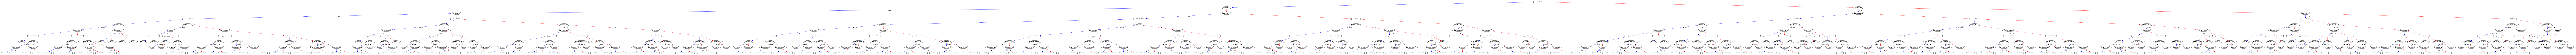

In [176]:
from graphviz import Digraph
from xgboost import plot_tree
import matplotlib.pyplot as plt

# 創建呈現在每一棵樹上的feature name
def create_feature_map(features):
    outfile = open("xgb.fmap", "w")
    i = 0
    for feat in features:
        outfile.write("{0}\t{1}\tq\t".format(i, feat))
        i = i+1
    outfile.close

create_feature_map(X_train.columns)
plot_tree(xgb, # 引入上面訓練好的xgb model 
          num_trees=0, # 第幾棵樹
          fmap="xgb.fmap") # 引入feature name

fig = plt.gcf()
fig.set_size_inches(570, 380)

plt.show()


In [49]:
for i in range(len(grid.cv_results_['rank_test_score'])):
    print('{:3d}'.format(grid.cv_results_['rank_test_score'][i]),end = '')
    if grid.cv_results_['rank_test_score'][i] < 10:
        print('_',end = '')
    else:
        print(' ',end = '')
    if i%9 == 8:
        print()

 33  32  31  27   8_ 28  15   6_  3_ 22  10  26   7_ 18   2_ 14  29  23  25  17   5_ 11  19   1_  4_ 30   9_ 13  12  21  24  20 
 16 

In [7]:


#for grid search cv
# params = {'learning_rate': 0.1, 'n_estimators': 16, 'max_depth': 10, 'min_child_weight': 1, 'seed': 0,
#                     'subsample': 0.87, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 16, 'reg_lambda': 1,"early_stopping_rounds":20}

# xgb = xgboost.XGBRegressor(**params)



In [78]:
#old grid search cv
# grid = sklearn.model_selection.GridSearchCV(estimator=xgb, param_grid=cv_params, scoring='r2', verbose=4,cv = cv)

# grid.fit(X_train, y_train,
#         eval_set=[(X_train,y_train)],
#         verbose=False)
# print('参数的最佳取值：{0}'.format(grid.best_params_))
# print('最佳模型得分:{0}'.format(grid.best_score_))
# print(grid.cv_results_['rank_test_score'])
# print(grid.cv_results_)

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV 1/2] END .....................learning_rate=1;, score=nan total time=   0.0s
[CV 2/2] END ..................learning_rate=1;, score=-1.910 total time=   0.0s
[CV 1/2] END .....................learning_rate=2;, score=nan total time=   0.0s
[CV 2/2] END ..................learning_rate=2;, score=-0.209 total time=   0.0s


C:\Users\chuang\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\chuang\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:796: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\chuang\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan]
  warnings.warn(


参数的最佳取值：{'learning_rate': 1}
最佳模型得分:nan
[1 2]
{'mean_fit_time': array([0.04458737, 0.04631114]), 'std_fit_time': array([0.00203395, 0.00075769]), 'mean_score_time': array([0.00200081, 0.00150001]), 'std_score_time': array([0.0010004 , 0.00050032]), 'param_learning_rate': masked_array(data=[1, 2],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 1}, {'learning_rate': 2}], 'split0_test_score': array([nan, nan]), 'split1_test_score': array([-1.91016906, -0.20859275]), 'mean_test_score': array([nan, nan]), 'std_test_score': array([nan, nan]), 'rank_test_score': array([1, 2])}
